In [1]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:95% !important; }div.output_wrapper .output { padding-left: 14px; }</style>"))

In [2]:
import tensorflow_gan as tfgan
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [3]:
train_orig = pd.read_csv('../../data/mnist/train.csv')
test_orig = pd.read_csv('../../data/mnist/test.csv')

train_orig.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    train_orig.drop("label", axis = 1), train_orig["label"], test_size=0.2, random_state=0)

In [5]:
big_X_train = X_train / 255.
big_X_test = X_test / 255.

In [6]:
def show_plots(data, x = 0, y = 690, z = 1699, c = 420) :
    plt.figure(1)
    plt.subplot(221)
    plt.imshow(data[x])

    plt.subplot(222)
    plt.imshow(data[y])

    plt.subplot(223)
    plt.imshow(data[z])

    plt.subplot(224)
    plt.imshow(data[c])
    plt.show()

In [7]:
import random

def show_image_grid(data, array = None):
    if array is None:
        array = random.sample(range(0, data.shape[0] - 1), 25)
    for index, item in enumerate(array):
        plt.subplot(5, 5, 1 + index)
        plt.axis('off')
        plt.imshow(data[item], cmap='gray_r')
    plt.show()

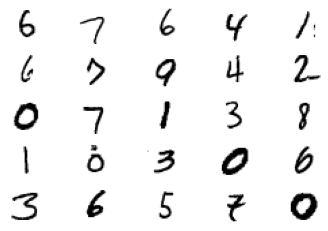

In [8]:
show_image_grid(big_X_train.values.reshape(-1, 28, 28))

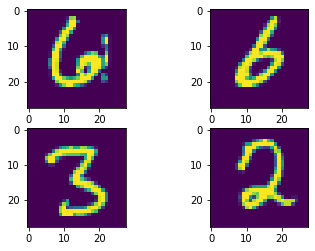

In [14]:
show_plots(big_X_train.values.reshape(-1, 28, 28))

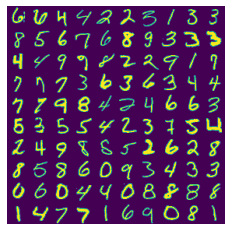

In [9]:
tensor_images = next(iter(tf.convert_to_tensor(np.transpose(big_X_train[0:100]))))
img_grid = tfgan.eval.python_image_grid(big_X_train[0:100].values.reshape(-1, 28, 28, 1), grid_shape=(10, 10))
plt.axis('off')
plt.imshow(np.squeeze(img_grid))
plt.show()

In [45]:
import inspect
inspect.getsource(tfgan.eval.python_image_grid)

'def python_image_grid(input_array, grid_shape):\n  """This is a pure python version of tfgan.eval.image_grid.\n\n  Args:\n    input_array: ndarray. Minibatch of images to format. A 4D numpy array\n        ([batch size, height, width, num_channels]).\n    grid_shape: Sequence of int. The shape of the image grid,\n        formatted as [grid_height, grid_width].\n\n  Returns:\n    Numpy array representing a single image in which the input images have been\n    arranged into a grid.\n\n  Raises:\n    ValueError: The grid shape and minibatch size don\'t match.\n    ValueError: The input array isn\'t 4D.\n  """\n  if grid_shape[0] * grid_shape[1] != int(input_array.shape[0]):\n    raise ValueError("Grid shape %s incompatible with minibatch size %i." %\n                     (grid_shape, int(input_array.shape[0])))\n  if len(input_array.shape) != 4:\n    raise ValueError("Unrecognized input array format.")\n  image_shape = input_array.shape[1:3]\n  num_channels = input_array.shape[3]\n  heigh

To build our GAN we need two separate networks:

A generator that takes input noise and outputs generated MNIST digits


A discriminator that takes images and outputs a probability of being real or fake

we're going to have to build both networks ourselves. tfgan doesn't come with models. tfgan accepts a generator and discriminator models along with the real data and the noise data input to create a gan model. you then specify a gan loss function and create the train ops, which specifies an algorithm for model optimization (gradient descent, adam optimizer etc.). the model is then run. pretty straightforward. <br><br>
if you know how to build a generator and a discriminator models, that is.

# Using tfgan

a discriminator is a model with a binary output that classifies a bunch of images as either fake or real. the performance of the discriminator model is used to update the weights of both the discriminator and the generator models.

a generator takes as input a point from the latent space and generates a new sample. a latent space is a multi-dim vector space of hidden or unobserved vars -> latent vars.

only the discriminator model gets a hold of the images. a generator accepts as input randomly generated latent space representations and then generates an image, which the discriminator then classifies as either fake or real. the weights of the generator model are adjusted till it starts producing more of "real" images, but it never actually sees the images themselves. a discriminator is a model that learns to generate "real" images from essentially noise at first. Latent space has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, MNIST images, that only the generator knows how to turn into plausible MNIST images.

all of the layers in the discriminator are to be marked as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/08/top-5-gan-libraries-you-must-know/
# DON'T EXECUTE!!!! code template
# Set up the input.
images = mnist_data_provider.provide_data(FLAGS.batch_size)
noise = tf.random_normal([FLAGS.batch_size, FLAGS.noise_dims])

# Build the generator and discriminator.
gan_model = tfgan.gan_model(
    generator_fn=mnist.unconditional_generator,  # you define
    discriminator_fn=mnist.unconditional_discriminator,  # you define
    real_data=images,
    generator_inputs=noise)

# Build the GAN loss.
gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=tfgan_losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan_losses.wasserstein_discriminator_loss)

# Create the train ops, which calculate gradients and apply updates to weights.
train_ops = tfgan.gan_train_ops(
    gan_model,
    gan_loss,
    generator_optimizer=tf.train.AdamOptimizer(gen_lr, 0.5),
    discriminator_optimizer=tf.train.AdamOptimizer(dis_lr, 0.5))

# Run the train ops in the alternating training scheme.
tfgan.gan_train(
    train_ops,
    hooks=[tf.train.StopAtStepHook(num_steps=FLAGS.max_number_of_steps)],
    logdir=FLAGS.train_log_dir)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Reshape
from keras.utils.vis_utils import plot_model

from tensorflow.keras.layers import Conv2DTranspose
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [7]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape)) # larger stride to compensate for the lack of pooling layers
    # scales down to 14x14
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same')) # scales down to 7x7
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [8]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7 # We don’t just want one low-resolution version of the image; 
    # we want many parallel versions or interpretations of the input. This is a pattern in convolutional neural networks
    # where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, 
    # with different interpretations of the input. Therefore, the first hidden layer, the Dense, needs enough nodes
    # for multiple low-resolution versions of our output image, such as 128.
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    # conv2DTranspose is a conv operation that's learned while training the model. it will upsample the input.
    # it's like upsample2D + conv2D but more complex and modern.
    # a stride of (2×2) will quadruple the area of the input feature maps (double their width and height dimensions)
    
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [9]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [125]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [11]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
    X_real = X_real.values.reshape(-1, 28, 28, 1)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [57]:
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset.iloc[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

In [128]:
# train the generator and discriminator
# the model is updated in batches. # of epochs is the number of passes through the entire dataset
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X_real = X_real.values.reshape(-1, 28, 28, 1)
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0: # every 10th epoch
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = big_X_train
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/131, d=0.706, g=0.727
>1, 2/131, d=0.690, g=0.754
>1, 3/131, d=0.686, g=0.770
>1, 4/131, d=0.676, g=0.795
>1, 5/131, d=0.667, g=0.809
>1, 6/131, d=0.656, g=0.834
>1, 7/131, d=0.654, g=0.852
>1, 8/131, d=0.646, g=0.861
>1, 9/131, d=0.642, g=0.866
>1, 10/131, d=0.641, g=0.861
>1, 11/131, d=0.642, g=0.850
>1, 12/131, d=0.645, g=0.829
>1, 13/131, d=0.649, g=0.796
>1, 14/131, d=0.655, g=0.772
>1, 15/131, d=0.660, g=0.750
>1, 16/131, d=0.660, g=0.734
>1, 17/131, d=0.657, g=0.725
>1, 18/131, d=0.654, g=0.718
>1, 19/131, d=0.649, g=0.712
>1, 20/131, d=0.643, g=0.709
>1, 21/131, d=0.633, g=0.707
>1, 22/131, d=0.627, g=0.706
>1, 23/131, d=0.619, g=0.706
>1, 24/131, d=0.612, g=0.706
>1, 25/131, d=0.607, g=0.706
>1, 26/131, d=0.598, g=0.706
>1, 27/131, d=0.582, g=0.707
>1, 28/131, d=0.577, g=0.707
>1, 29/131, d=0.572, g=0.708
>1, 30/131, d=0.558, g=0.708
>1, 31/131, d=0.548, g=0.710
>1, 32/131, d=0.543, g=0.711
>1, 33/131, d=0.532, g=0.712
>1, 34/131, d=0.520, g=0.713
>1, 35/131, d=0.517, g=

>3, 21/131, d=0.660, g=0.791
>3, 22/131, d=0.701, g=0.713
>3, 23/131, d=0.684, g=0.661
>3, 24/131, d=0.737, g=0.636
>3, 25/131, d=0.725, g=0.624
>3, 26/131, d=0.749, g=0.608
>3, 27/131, d=0.744, g=0.593
>3, 28/131, d=0.729, g=0.570
>3, 29/131, d=0.698, g=0.588
>3, 30/131, d=0.731, g=0.583
>3, 31/131, d=0.736, g=0.590
>3, 32/131, d=0.793, g=0.598
>3, 33/131, d=0.769, g=0.641
>3, 34/131, d=0.757, g=0.657
>3, 35/131, d=0.774, g=0.689
>3, 36/131, d=0.752, g=0.708
>3, 37/131, d=0.758, g=0.746
>3, 38/131, d=0.766, g=0.733
>3, 39/131, d=0.749, g=0.748
>3, 40/131, d=0.760, g=0.742
>3, 41/131, d=0.736, g=0.741
>3, 42/131, d=0.755, g=0.773
>3, 43/131, d=0.717, g=0.771
>3, 44/131, d=0.721, g=0.754
>3, 45/131, d=0.710, g=0.787
>3, 46/131, d=0.680, g=0.730
>3, 47/131, d=0.686, g=0.735
>3, 48/131, d=0.680, g=0.788
>3, 49/131, d=0.699, g=0.752
>3, 50/131, d=0.682, g=0.760
>3, 51/131, d=0.686, g=0.778
>3, 52/131, d=0.677, g=0.767
>3, 53/131, d=0.660, g=0.748
>3, 54/131, d=0.658, g=0.765
>3, 55/131, d=

In [ ]:
# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)